## Route Optimization:
The first of this notebook contains lines of codes demonstarting how to find a shortest weighted path between two points on the map given by their latitude and longtitude for the starbucks dataset using osmnx library: https://www.kaggle.com/datasets/starbucks/store-locations.

We followed the steps explained in this blog: https://towardsdatascience.com/modern-route-optimization-with-python-fea87d34288b

In the second part of the notebook, we pick some artibitrary entries of the Chicago dataset, and followed the exact steps outlined in the blog above to find the shortest path in terms of distance as well as the travel time.

In [ ]:
!pip install osmnx networkx ortools --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 59.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-datastore 2.19.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.26.1 which is incompatible.
g

In [ ]:
# !pip install networkx ortools

In [ ]:
## for data
import pandas as pd  #1.1.5
import numpy as np  #1.21.0

## for plotting
import matplotlib.pyplot as plt  #3.3.2
import seaborn as sns  #0.11.1
import folium  #0.14.0
from folium import plugins
import plotly.express as px  #5.1.0

## for simple routing
import osmnx as ox  #1.2.2
import networkx as nx  #3.0

## for advanced routing
from ortools.constraint_solver import pywrapcp  #9.6
from ortools.constraint_solver import routing_enums_pb2

### Starbucks location dataset

In [ ]:
df = pd.read_csv('starbucks_stores.csv')

In [ ]:
df.shape

(25600, 13)

In [ ]:
df.head(3)

Brand  Store Number        Store Name Ownership Type  \
0  Starbucks  47370-257954     Meritxell, 96       Licensed   
1  Starbucks  22331-212325  Ajman Drive Thru       Licensed   
2  Starbucks  47089-256771         Dana Mall       Licensed   

                 Street Address              City State/Province Country  \
0             Av. Meritxell, 96  Andorra la Vella              7      AD   
1          1 Street 69, Al Jarf             Ajman             AJ      AE   
2  Sheikh Khalifa Bin Zayed St.             Ajman             AJ      AE   

  Postcode Phone Number                 Timezone  Longitude  Latitude  
0    AD500    376818720  GMT+1:00 Europe/Andorra       1.53     42.51  
1      NaN          NaN     GMT+04:00 Asia/Dubai      55.47     25.42  
2      NaN          NaN     GMT+04:00 Asia/Dubai      55.47     25.39

In [ ]:
'Chicago' in df['City'].unique()

True

In [ ]:
city = 'Chicago'

df = df[df["City"]==city][
        ["City","Street Address","Latitude","Longitude"]
      ].reset_index(drop=True)
df = df.reset_index().rename(
      columns={"index":"id", "Latitude":"y", "Longitude":"x"})

print("tot:", len(df))
df.head(3)

tot: 180


id     City       Street Address      y      x
0   0  Chicago  1101 W Jackson Blvd  41.88 -87.65
1   1  Chicago    40 N. Clinton St.  41.88 -87.64
2   2  Chicago   1003 N Rush Street  41.90 -87.63

In [ ]:
df.shape

(180, 5)

In [ ]:
# pinpoint your starting location
i = 0
df["base"] = df["id"].apply(lambda x: 1 if x==i else 0)
start = df[df["base"]==1][["y","x"]].values[0]

print("start =", start)
df.head(3)

start = [ 41.88 -87.65]


id     City       Street Address      y      x  base
0   0  Chicago  1101 W Jackson Blvd  41.88 -87.65     1
1   1  Chicago    40 N. Clinton St.  41.88 -87.64     0
2   2  Chicago   1003 N Rush Street  41.90 -87.63     0

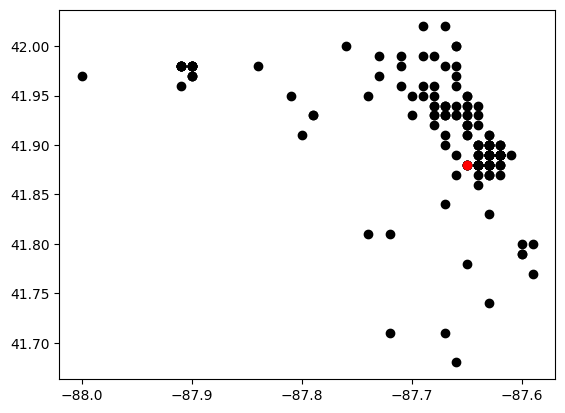

In [ ]:
plt.scatter(y=df["y"], x=df["x"], color="black")
plt.scatter(y=start[0], x=start[1], color="red")
plt.show()

In [ ]:
# setup
data = df.copy()
color = "base"  #color based on this column
lst_colors = ["black","red"]
popup = "id" #popup based on this column

# base map
map_ = folium.Map(location=start, tiles="cartodbpositron", zoom_start=11)

# add colors
lst_elements = sorted(list(data[color].unique()))
data["color"] = data[color].apply(lambda x:
                  lst_colors[lst_elements.index(x)])

# add popup
data.apply(lambda row:
    folium.CircleMarker(
            location=[row["y"],row["x"]], popup=row[popup],
            color=row["color"], fill=True, radius=5).add_to(map_),
    axis=1)

# add full-screen button
plugins.Fullscreen(position="topright", title="Expand",
      title_cancel="Exit", force_separate_button=True).add_to(map_)

# show
map_

In [ ]:
# add lines
for i in range(len(df)):
    points = [start, df[["y","x"]].iloc[i].tolist()]
    folium.PolyLine(points, tooltip="Coast", color="red",
                    weight=0.5, opacity=0.5).add_to(map_)

map_

In [ ]:
# import folium
# from folium import plugins

# # ... (previous code)

# layers = ["cartodbpositron", "openstreetmap", "Stamen Terrain",
#           "Stamen Water Color", "Stamen Toner", "cartodbdark_matter"]

# # Dictionary to store attributions for each tile layer
# attributions = {
#     "cartodbpositron": '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
#     "openstreetmap": '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
#     "Stamen Terrain": 'Map tiles by <a href="http://stamen.com">Stamen Design</a>, <a href="http://creativecommons.org/licenses/by/3.0">CC BY 3.0</a> &mdash; Data by <a href="http://openstreetmap.org">OpenStreetMap</a>, under <a href="http://www.openstreetmap.org/copyright">ODbL</a>.',
#     "Stamen Water Color": 'Map tiles by <a href="http://stamen.com">Stamen Design</a>, <a href="http://creativecommons.org/licenses/by/3.0">CC BY 3.0</a> &mdash; Data by <a href="http://openstreetmap.org">OpenStreetMap</a>, under <a href="http://creativecommons.org/licenses/by-sa/3.0">CC BY SA</a>.',
#     "Stamen Toner": 'Map tiles by <a href="http://stamen.com">Stamen Design</a>, <a href="http://creativecommons.org/licenses/by/3.0">CC BY 3.0</a> &mdash; Data by <a href="http://openstreetmap.org">OpenStreetMap</a>, under <a href="http://www.openstreetmap.org/copyright">ODbL</a>.',
#     "cartodbdark_matter": '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>'
# }


# for tile in layers:
#     # Get the attribution for the current tile
#     attribution = attributions.get(tile, '')  # Default to empty string if not found

#     # Add the tile layer with attribution
#     folium.TileLayer(tiles=tile, attr=attribution).add_to(map_)

# folium.LayerControl(position='bottomright').add_to(map_)
# map_

/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


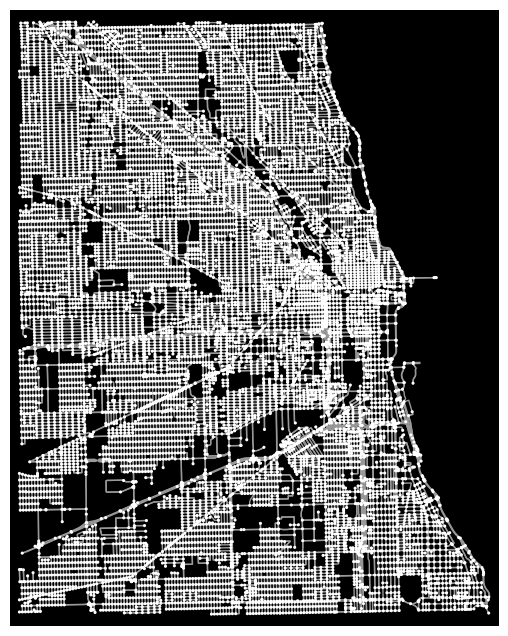

In [ ]:
# create network graph
G = ox.graph_from_point(start, dist=10000,
        network_type="drive")  #'drive', 'bike', 'walk'
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# plot
fig, ax = ox.plot_graph(G, bgcolor="black", node_size=5,
        node_color="white", figsize=(16,8))

In [ ]:
# geo-dataframe (nodes)
print("nodes:", len(G.nodes()))
ox.graph_to_gdfs(G, nodes=True, edges=False).reset_index().head(3)

nodes: 14728


osmid          y          x  street_count  ref            highway  \
0  25779161  41.900902 -87.660921             3  NaN                NaN   
1  25779173  41.895018 -87.657114             3  50B  motorway_junction   
2  25779189  41.884284 -87.646074             3  51D  motorway_junction   

                     geometry  
0  POINT (-87.66092 41.90090)  
1  POINT (-87.65711 41.89502)  
2  POINT (-87.64607 41.88428)

In [ ]:
# geo-dataframe (links)
print("links:", len(G.edges()))
ox.graph_to_gdfs(G, nodes=False, edges=True).reset_index().head(3)

links: 37924


u           v  key                                      osmid  \
0  25779161   739968328    0                                    4378009   
1  25779173   709393336    0  [24229922, 56716748, 56716749, 898010482]   
2  25779173  4503178589    0           [26233560, 906195924, 435659095]   

   oneway   lanes        ref                name        highway maxspeed  ...  \
0    True       4  I 90;I 94  Kennedy Expressway       motorway   45 mph  ...   
1    True  [2, 3]        NaN                 NaN  motorway_link      NaN  ...   
2    True  [5, 4]  I 90;I 94  Kennedy Expressway       motorway   45 mph  ...   

    length                                           geometry speed_kph  \
0  354.287  LINESTRING (-87.66092 41.90090, -87.66068 41.9...      72.4   
1  828.773  LINESTRING (-87.65711 41.89502, -87.65684 41.8...      76.4   
2  291.838  LINESTRING (-87.65711 41.89502, -87.65651 41.8...      72.4   

   travel_time  bridge tunnel width access area junction  
0         17.6     NaN    NaN   NaN    NaN  NaN      NaN  
1         39.1     yes    NaN   NaN    NaN  NaN      NaN  
2         14.5     NaN    NaN   NaN    NaN  NaN      NaN  

[3 rows x 21 columns]

In [ ]:
end = df[df["id"]==68][["y","x"]].values[0]
print("locations: from", start, "--> to", end)

locations: from [ 41.88 -87.65] --> to [ 41.98 -87.9 ]


In [ ]:
start_node = ox.distance.nearest_nodes(G, start[1], start[0])
end_node = ox.distance.nearest_nodes(G, end[1], end[0])
print("nodes: from", start_node, "--> to", end_node)

nodes: from 261886238 --> to 261237485


[261886238, 288070420, 288070450, 35313343, 287262182, 287257360, 287257359, 709360214, 26792901, 709393162, 26792889, 739968170, 26792886, 26704134, 26704140, 12207722125, 2998820402, 26704159, 9233058524, 9233058522, 26704163, 26704168, 2998826803, 26704178, 8816415897, 26704186, 26704188, 26704211, 26704212, 26704221, 26704226, 1385442905, 26704233, 26704235, 26704238, 266651196, 256170758, 256170759, 12236479202, 12236459398, 261160338, 261237413, 102812059, 6162746801, 261210243, 261233929, 305906681, 266720646, 105254026, 266720519, 266720512, 261144522, 261237485]


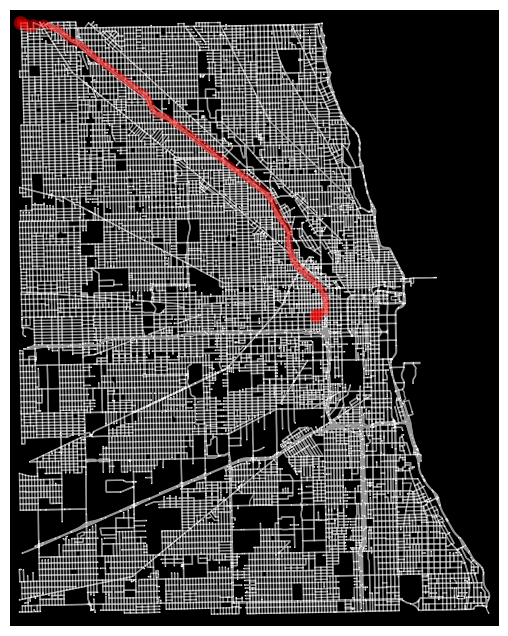

In [ ]:
# calculate shortest path
path_lenght = nx.shortest_path(G, source=start_node, target=end_node,
                                method='dijkstra', weight='lenght')
print(path_lenght)

# plot on the graph
fig, ax = ox.plot_graph_route(G, path_lenght, route_color="red",
                              route_linewidth=5, node_size=1,
                              bgcolor='black', node_color="white",
                              figsize=(16,8))

[261886238, 288070420, 288070450, 35313343, 287262182, 287257360, 287257359, 709360214, 26792901, 709393162, 26792889, 739968170, 26792886, 26704134, 26704140, 12207722125, 2998820402, 26704159, 9233058524, 9233058522, 26704163, 26704168, 2998826803, 26704178, 8816415897, 26704186, 26704188, 26704211, 26704212, 26704221, 26704226, 1385442905, 26704233, 26704235, 26704238, 266651196, 256170758, 256170759, 12236479202, 12236459398, 12236459399, 10278623786, 288470906, 256170760, 288471023, 305906578, 305906582, 305906681, 266720646, 105254026, 266720640, 266720632, 261266703, 261237485]


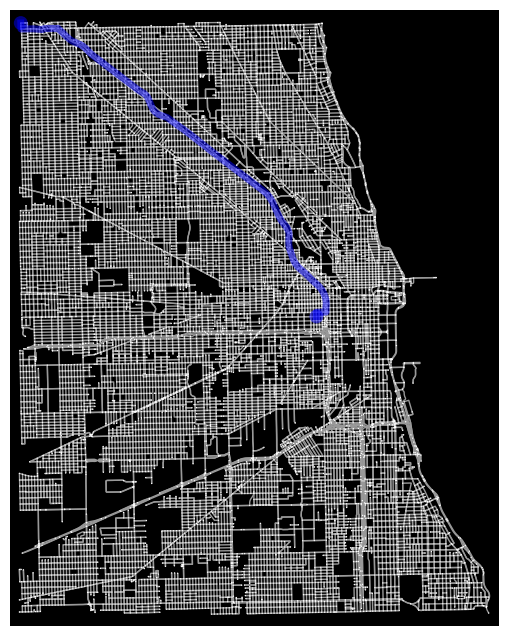

In [ ]:
# calculate shortest path
path_time = nx.shortest_path(G, source=start_node, target=end_node,
                              method='dijkstra', weight='travel_time')
print(path_time)

# plot on the graph
fig, ax = ox.plot_graph_route(G, path_time, route_color="blue",
                              route_linewidth=5, node_size=1,
                              bgcolor='black', node_color="white",
                              figsize=(16,8))

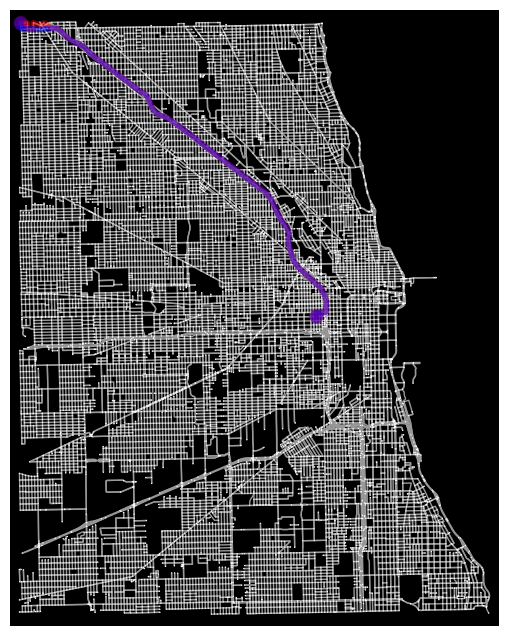

In [ ]:
# plot on the graph
fig, ax = ox.plot_graph_routes(G, routes=[path_lenght, path_time],
                              route_colors=["red","blue"],
                              route_linewidth=5, node_size=1,
                              bgcolor='black', node_color="white",
                              figsize=(16,8))

In [ ]:
# plot on the map
ox.plot_route_folium(G, route=path_lenght, route_map=map_,
                     color="red", weight=1)
ox.plot_route_folium(G, route=path_time, route_map=map_,
                     color="blue", weight=1)
map_

<ipython-input-29-6a3d4d689b1b>:2: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_route_folium(G, route=path_lenght, route_map=map_,
<ipython-input-29-6a3d4d689b1b>:4: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_route_folium(G, route=path_time, route_map=map_,


In [ ]:
lst_start, lst_end = [],[]
start_x, start_y = [],[]
end_x, end_y = [],[]
lst_length, lst_time = [],[]

for a,b in zip(path_time[:-1], path_time[1:]):
    lst_start.append(a)
    lst_end.append(b)
    lst_length.append(round(G.edges[(a,b,0)]['length']))
    lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
    start_x.append(G.nodes[a]['x'])
    start_y.append(G.nodes[a]['y'])
    end_x.append(G.nodes[b]['x'])
    end_y.append(G.nodes[b]['y'])

df = pd.DataFrame(list(zip(lst_start, lst_end,
                           start_x, start_y, end_x, end_y,
                           lst_length, lst_time)),
                   columns=["start","end","start_x","start_y",
                            "end_x","end_y","length","travel_time"]
                  ).reset_index().rename(columns={"index":"id"})

df.head()

id      start        end    start_x    start_y      end_x      end_y  \
0   0  261886238  288070420 -87.649654  41.880461 -87.649697  41.881744   
1   1  288070420  288070450 -87.649697  41.881744 -87.648532  41.881763   
2   2  288070450   35313343 -87.648532  41.881763 -87.647361  41.881782   
3   3   35313343  287262182 -87.647361  41.881782 -87.646489  41.881792   
4   4  287262182  287257360 -87.646489  41.881792 -87.645827  41.881800   

   length  travel_time  
0     143           16  
1      96            8  
2      97            8  
3      72            6  
4      55            5

In [ ]:
## create start/end df
df_start = df[df["start"] == start_node]
df_end = df[df["end"] == end_node]

## create basic map
fig = px.scatter_mapbox(data_frame=df, lon="start_x", lat="start_y",
                        zoom=15, width=1000, height=800,
                        animation_frame="id",
                        mapbox_style="carto-positron")
## add driver
fig.data[0].marker = {"size":12}
## add start point
fig.add_trace(px.scatter_mapbox(data_frame=df_start,
                                lon="start_x", lat="start_y").data[0])
fig.data[1].marker = {"size":15, "color":"red"}
## add end point
fig.add_trace(px.scatter_mapbox(data_frame=df_end,
                                lon="start_x", lat="start_y").data[0])
fig.data[2].marker = {"size":15, "color":"green"}
## add route
fig.add_trace(px.line_mapbox(data_frame=df,
                             lon="start_x", lat="start_y").data[0])
fig

## Chicago Dataset

In [1]:
## Getting the chicago dataset for the second week of May 2024
api_url = "https://data.cityofchicago.org/resource/n26f-ihde.csv?$query=SELECT%20trip_id%2C%20trip_start_timestamp%2C%20trip_end_timestamp%2C%20trip_seconds%2C%20trip_miles%2C%20percent_time_chicago%2C%20percent_distance_chicago%2C%20pickup_census_tract%2C%20dropoff_census_tract%2C%20pickup_community_area%2C%20dropoff_community_area%2C%20fare%2C%20tip%2C%20additional_charges%2C%20trip_total%2C%20shared_trip_authorized%2C%20shared_trip_match%2C%20trips_pooled%2C%20pickup_centroid_latitude%2C%20pickup_centroid_longitude%2C%20pickup_centroid_location%2C%20dropoff_centroid_latitude%2C%20dropoff_centroid_longitude%2C%20dropoff_centroid_location%20WHERE%20trip_start_timestamp%20BETWEEN%20'2024-01-01T00:00:00'%20AND%20'2024-06-30T23:59:59'"

In [ ]:
import requests

# Base URL for the API
# base_url = "https://data.cityofchicago.org/resource/n26f-ihde.csv"


# Set the number of rows to download (625,000 rows)
rows_to_download = 2000000

# Create a file to store the dataset
output_file = 'data_2024_May_W2.csv'

# Construct the URL with limit
# url = f"{base_url}?$select=trip_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,percent_time_chicago,percent_distance_chicago,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tip,additional_charges,trip_total,shared_trip_authorized,shared_trip_match,trips_pooled,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location&$limit={rows_to_download}"
url = api_url = api_url = "https://data.cityofchicago.org/resource/n26f-ihde.csv?$query=SELECT%20trip_id%2C%20trip_start_timestamp%2C%20trip_end_timestamp%2C%20trip_seconds%2C%20trip_miles%2C%20percent_time_chicago%2C%20percent_distance_chicago%2C%20pickup_census_tract%2C%20dropoff_census_tract%2C%20pickup_community_area%2C%20dropoff_community_area%2C%20fare%2C%20tip%2C%20additional_charges%2C%20trip_total%2C%20shared_trip_authorized%2C%20shared_trip_match%2C%20trips_pooled%2C%20pickup_centroid_latitude%2C%20pickup_centroid_longitude%2C%20pickup_centroid_location%2C%20dropoff_centroid_latitude%2C%20dropoff_centroid_longitude%2C%20dropoff_centroid_location%20WHERE%20trip_start_timestamp%20BETWEEN%20'2024-05-08T00:00:00'%20AND%20'2024-05-14T23:59:59'%20LIMIT%202000000"



try:
    # Download the data
    response = requests.get(url, timeout=60)
    response.raise_for_status()

    # Save the data to a CSV file
    with open(output_file, 'wb') as f:
        f.write(response.content)

    print(f"Successfully downloaded the data.")

except requests.exceptions.ReadTimeout:
    print(f"The request timed out. Please try again later.")
except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")


In [ ]:
import pandas as pd

# Load the CSV file into a DataFrame

# data = pd.read_csv("data_200MB.csv")
data = pd.read_csv("data_2024_May_W2.csv")

In [ ]:
data.shape

In [ ]:
data.head(3)

### Finding the shortest path for a random entry of the Chicago dataset

In [ ]:
import pandas as pd

# Filter rows where specific columns are not null
filtered_data = df.dropna(subset=[
    'y1', 'x1', 'y2', 'x2'
])

# Select a random row from the filtered DataFrame
random_entry = filtered_data.sample(n=1)

print(random_entry)


            id         y1         x1         y2         x2
625037  625037  41.890922 -87.618868  41.914747 -87.654007


In [ ]:
# Create a list containing 'pickup_centroid_latitude' and 'pickup_centroid_longitude' from the random entry
start = list(random_entry[['y1', 'x1']].values[0])

print("start =", start)



start = [41.8909220259, -87.6188683546]


In [ ]:
# Create a list containing 'drop_off_centroid_latitude' and 'drop_off_centroid_longitude' from the random entry
end = list(random_entry[['y2', 'x2']].values[0])

print("end =", end)

end = [41.9147473049, -87.6540070286]


/usr/local/lib/python3.10/dist-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


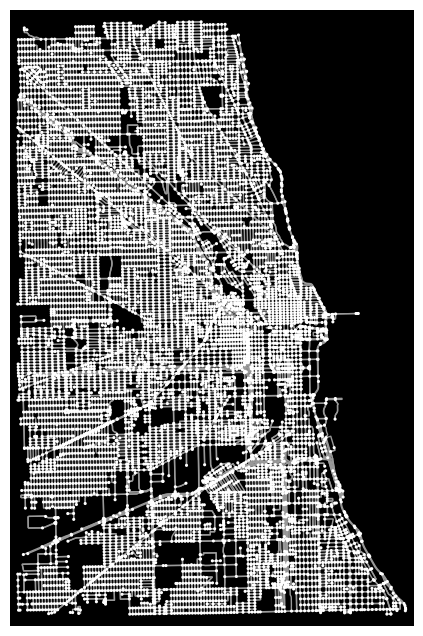

In [ ]:
# create network graph
G = ox.graph_from_point(start, dist=10000,
        network_type="drive")  #'drive', 'bike', 'walk'
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# plot
fig, ax = ox.plot_graph(G, bgcolor="black", node_size=5,
        node_color="white", figsize=(16,8))

In [ ]:
print("nodes:", len(G.nodes()))
ox.graph_to_gdfs(G, nodes=True, edges=False).reset_index().head(3)

nodes: 11789


osmid          y          x  street_count  ref            highway  \
0  25779161  41.900902 -87.660921             3  NaN                NaN   
1  25779173  41.895018 -87.657114             3  50B  motorway_junction   
2  25779189  41.884284 -87.646074             3  51D  motorway_junction   

                     geometry  
0  POINT (-87.66092 41.90090)  
1  POINT (-87.65711 41.89502)  
2  POINT (-87.64607 41.88428)

In [ ]:
# geo-dataframe (links)
print("links:", len(G.edges()))
ox.graph_to_gdfs(G, nodes=False, edges=True).reset_index().head(3)

links: 30530


u           v  key                                      osmid  \
0  25779161   739968328    0                                    4378009   
1  25779173   709393336    0  [24229922, 56716748, 56716749, 898010482]   
2  25779173  4503178589    0           [26233560, 906195924, 435659095]   

   oneway   lanes        ref                name        highway maxspeed  ...  \
0    True       4  I 90;I 94  Kennedy Expressway       motorway   45 mph  ...   
1    True  [3, 2]        NaN                 NaN  motorway_link      NaN  ...   
2    True  [5, 4]  I 90;I 94  Kennedy Expressway       motorway   45 mph  ...   

    length                                           geometry speed_kph  \
0  354.287  LINESTRING (-87.66092 41.90090, -87.66068 41.9...      72.4   
1  828.773  LINESTRING (-87.65711 41.89502, -87.65684 41.8...      76.4   
2  291.838  LINESTRING (-87.65711 41.89502, -87.65651 41.8...      72.4   

   travel_time  bridge width tunnel access area junction  
0         17.6     NaN   NaN    NaN    NaN  NaN      NaN  
1         39.1     yes   NaN    NaN    NaN  NaN      NaN  
2         14.5     NaN   NaN    NaN    NaN  NaN      NaN  

[3 rows x 21 columns]

In [ ]:
start_node = ox.distance.nearest_nodes(G, start[1], start[0])
end_node = ox.distance.nearest_nodes(G, end[1], end[0])
print("nodes: from", start_node, "--> to", end_node)

nodes: from 269448563 --> to 265641952


[269448563, 736918429, 736862196, 261179547, 262184061, 261151125, 261179549, 262184019, 261146027, 261161069, 269446291, 261149258, 261149259, 261149260, 261147787, 261149261, 261149262, 250755819, 261149265, 261149266, 4043180079, 250755813, 102713553, 344804280, 250755798, 2291929257, 102713551, 263984851, 263984850, 344357797, 102708200, 263984856, 263984857, 102708201, 263984906, 263985031, 102708202, 11891975106, 263983553, 739321961, 263983704, 265641952]


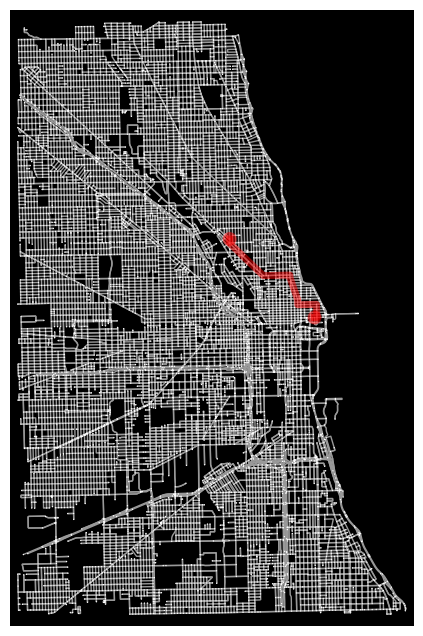

In [ ]:
# calculate shortest path
path_lenght = nx.shortest_path(G, source=start_node, target=end_node,
                                method='dijkstra', weight='length')
print(path_lenght)

# plot on the graph
fig, ax = ox.plot_graph_route(G, path_lenght, route_color="red",
                              route_linewidth=5, node_size=1,
                              bgcolor='black', node_color="white",
                              figsize=(16,8))

[269448563, 736918429, 736862196, 258023343, 258023461, 258965934, 262184057, 262184019, 262183798, 257164245, 27440566, 27440482, 269446280, 262906828, 261149260, 261147787, 261149261, 261149262, 250755819, 261149265, 261149266, 4043180079, 250755813, 102713553, 344804280, 250755798, 2291929257, 102713551, 263984851, 263984850, 344357797, 102708200, 263984856, 263984857, 102708201, 263984906, 263985031, 102708202, 11891975106, 263983553, 739321961, 263983704, 265641952]


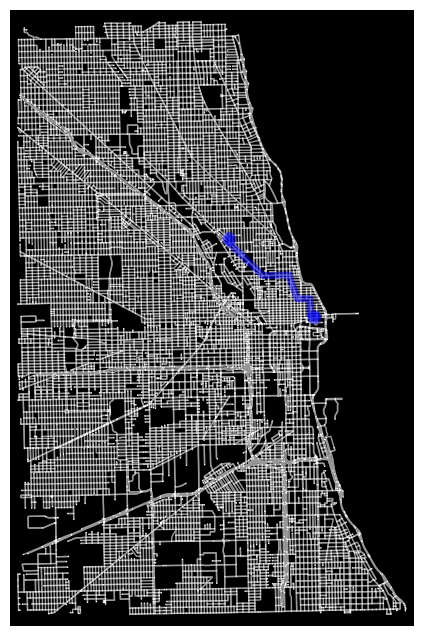

In [ ]:
# calculate shortest path
path_time = nx.shortest_path(G, source=start_node, target=end_node,
                              method='dijkstra', weight='travel_time')
print(path_time)

# plot on the graph
fig, ax = ox.plot_graph_route(G, path_time, route_color="blue",
                              route_linewidth=5, node_size=1,
                              bgcolor='black', node_color="white",
                              figsize=(16,8))

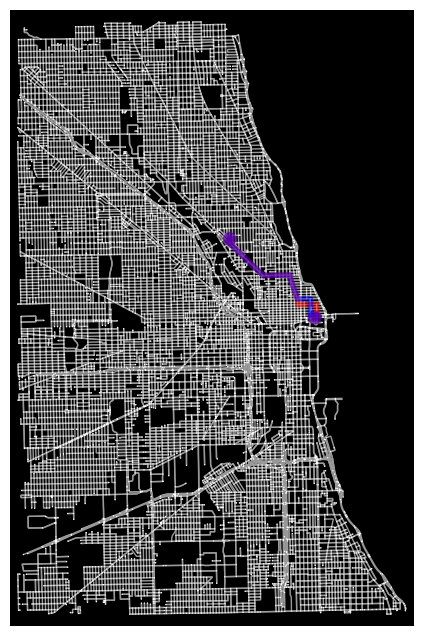

In [ ]:
# plot on the graph
fig, ax = ox.plot_graph_routes(G, routes=[path_lenght, path_time],
                              route_colors=["red","blue"],
                              route_linewidth=5, node_size=1,
                              bgcolor='black', node_color="white",
                              figsize=(16,8))

In [ ]:
# base map
map_ = folium.Map(location=start, tiles="cartodbpositron", zoom_start=11)

In [ ]:
# plot on the map
ox.plot_route_folium(G, route=path_lenght, route_map=map_,
                     color="red", weight=1)
ox.plot_route_folium(G, route=path_time, route_map=map_,
                     color="blue", weight=1)
map_

<ipython-input-26-11c8805a4ce3>:2: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_route_folium(G, route=path_lenght, route_map=map_,
<ipython-input-26-11c8805a4ce3>:4: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_route_folium(G, route=path_time, route_map=map_,


In [ ]:
lst_start, lst_end = [],[]
start_x, start_y = [],[]
end_x, end_y = [],[]
lst_length, lst_time = [],[]

for a,b in zip(path_time[:-1], path_time[1:]):
    lst_start.append(a)
    lst_end.append(b)
    lst_length.append(round(G.edges[(a,b,0)]['length']))
    lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
    start_x.append(G.nodes[a]['x'])
    start_y.append(G.nodes[a]['y'])
    end_x.append(G.nodes[b]['x'])
    end_y.append(G.nodes[b]['y'])

df = pd.DataFrame(list(zip(lst_start, lst_end,
                           start_x, start_y, end_x, end_y,
                           lst_length, lst_time)),
                   columns=["start","end","start_x","start_y",
                            "end_x","end_y","length","travel_time"]
                  ).reset_index().rename(columns={"index":"id"})

df.head()

id      start        end    start_x    start_y      end_x      end_y  \
0   0  269448563  736918429 -87.618610  41.891051 -87.617665  41.891067   
1   1  736918429  736862196 -87.617665  41.891067 -87.617688  41.891833   
2   2  736862196  258023343 -87.617688  41.891833 -87.620235  41.891803   
3   3  258023343  258023461 -87.620235  41.891803 -87.620263  41.892588   
4   4  258023461  258965934 -87.620263  41.892588 -87.620283  41.893412   

   length  travel_time  
0      78            7  
1      85            8  
2     211           18  
3      87            8  
4      92            8

In [ ]:
## create start/end df
df_start = df[df["start"] == start_node]
df_end = df[df["end"] == end_node]

## create basic map
fig = px.scatter_mapbox(data_frame=df, lon="start_x", lat="start_y",
                        zoom=15, width=1000, height=800,
                        animation_frame="id",
                        mapbox_style="carto-positron")
## add driver
fig.data[0].marker = {"size":12}
## add start point
fig.add_trace(px.scatter_mapbox(data_frame=df_start,
                                lon="start_x", lat="start_y").data[0])
fig.data[1].marker = {"size":15, "color":"red"}
## add end point
fig.add_trace(px.scatter_mapbox(data_frame=df_end,
                                lon="start_x", lat="start_y").data[0])
fig.data[2].marker = {"size":15, "color":"green"}
## add route
fig.add_trace(px.line_mapbox(data_frame=df,
                             lon="start_x", lat="start_y").data[0])
fig